In [15]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

from typing import List, Dict
from PIL import Image

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

import time

In [45]:
## Basic functions
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   


In [46]:
image = cv2.imread('luffy.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

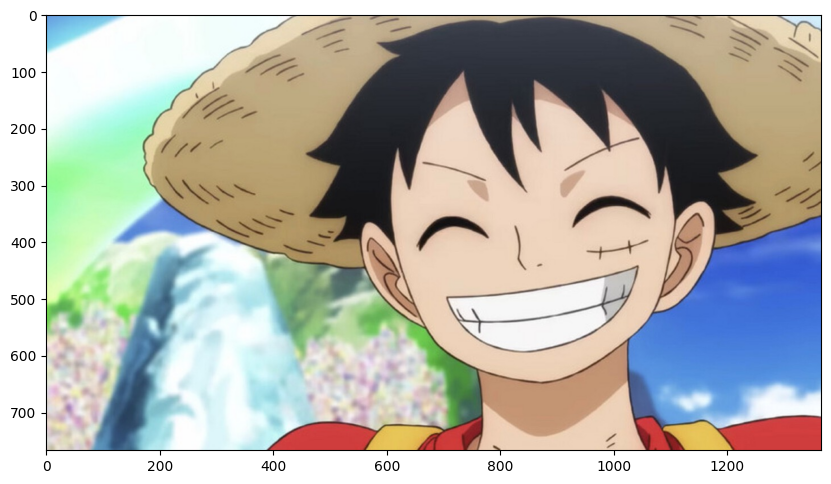

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Exporting ONNX Model

In [48]:
checkpoints = ["sam_vit_b_01ec64.pth", "sam_vit_h_4b8939.pth", "sam_vit_l_0b3195.pth"]
model_types = ["vit_b", "vit_h", "vit_l"]
onnx_model_paths = ["vit_b.onnx", "vit_h.onnx", "vit_l.onnx"]

In [49]:
checkpoint = "sam_vit_h_4b8939.pth" ## Replace with whichever sam model you are exporting
model_type = "vit_h"

In [50]:
for i in range(len(checkpoints)):
    import warnings
    
    sam = sam_model_registry[model_types[i]](checkpoint=checkpoints[i])
    onnx_model_path = onnx_model_paths[i]
    onnx_model = SamOnnxModel(sam, return_single_mask=True)

    dynamic_axes = {
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"},
    }

    embed_dim = sam.prompt_encoder.embed_dim
    embed_size = sam.prompt_encoder.image_embedding_size
    mask_input_size = [4 * x for x in embed_size]
    dummy_inputs = {
        "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
        "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
        "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
        "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
        "has_mask_input": torch.tensor([1], dtype=torch.float),
        "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
    }
    output_names = ["masks", "iou_predictions", "low_res_masks"]

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        with open(onnx_model_path, "wb") as f:
            torch.onnx.export(
                onnx_model,
                tuple(dummy_inputs.values()),
                f,
                export_params=True,
                verbose=False,
                opset_version=17,
                do_constant_folding=True,
                input_names=list(dummy_inputs.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )    

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Exporting Quantizied ONNX Model (Better Performance)

In [51]:
onnx_model_quantized_paths = ["vit_b_quantized.onnx", "vit_h_quantized.onnx", "vit_l_quantized.onnx"]
for i in range(len(onnx_model_paths)):
    onnx_model_quantized_path = onnx_model_quantized_paths[i]
    quantize_dynamic(
        model_input=onnx_model_paths[i],
        model_output=onnx_model_quantized_path,
        optimize_model=True,
        per_channel=False,
        reduce_range=False,
        weight_type=QuantType.QUInt8,
    )
    onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

__When finished the quantized version export, pass the 3 "quantized" files to backend/api/assets. Mantain the sam_vit... models. We will need them for inference.__ 

## Testing the Model

### A trip previous to ONNX

In [22]:
import time
start_time = time.time()

points = [[450, 375,1], [1000, 300, 1]]
image = cv2.imread('luffy.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

onnx_model_path = "vit_h.onnx"
checkpoint_path = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device="cpu")
predictor = SamPredictor(sam)
predictor.set_image(image)

In [23]:
def predict_mask1(
    input_point: np.ndarray, input_label: np.ndarray, predictor: SamPredictor
) -> np.ndarray:
    """Uses the model over some given points to generate a chosen mask given the input data."""
    # first pass
    _, pre_scores, pre_logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    mask_input = pre_logits[np.argmax(pre_scores), :, :]
    # second and final pass
    mask, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    mask = mask.squeeze()
    print(predictor)
    return mask

In [24]:
def gen_new_mask1(
    img: np.ndarray,
    points: List[List[int]],
    predictor: SamPredictor,
) -> Image:
    """Creates a new mask Image from input points and predictor model

    Args:
        img (np.ndarray): input image
        points (List[List[int]]): points for model
        predictor (SamPredictor): predictor with image embeddings already loaded

    Returns:
        Image: new mask
    """
    # coord transforming
    points_arr = np.array(points)
    points = points_arr[:, :2]
    labels = points_arr[:, -1]

    mask_img = np.zeros(img.shape, dtype=np.uint8)
    # if no points, mask is a completely transparent image
    if len(points) == 0:
        mask_img = Image.fromarray(mask_img)
        mask_img.putalpha(0)
        return mask_img

    mask = predict_mask1(points, labels, predictor)
    mask_img = np.zeros(img.shape, dtype=np.uint8)
    mask_img[mask] = img[mask]
    alpha_channel = np.zeros(img.shape[:2], dtype=np.uint8)
    alpha_channel[mask] = 255
    mask_img = Image.fromarray(mask_img)
    mask_img.putalpha(Image.fromarray(alpha_channel))
    return mask_img

In [25]:
start_time = time.time()
gen_new_mask1(image, points, predictor)
end_time = time.time()

In [26]:
elapsed_time = end_time - start_time
print(elapsed_time)

0.2662849426269531


### Now, with ONNX implemented

In [52]:
start_time = time.time()
points = [[450, 375,1], [1000, 300, 1]]
image = cv2.imread('luffy.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

onnx_model_path = "vit_h.onnx"
checkpoint_path = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device="cpu")
predictor = SamPredictor(sam)
predictor.set_image(image)

onnx_model_path = "vit_h_quantized.onnx" ## OK
ort_session = onnxruntime.InferenceSession(onnx_model_path)

image_embedding = predictor.get_image_embedding().detach().cpu().numpy()

In [53]:
onnx_model_path = "vit_h_quantized.onnx" ## OK
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [54]:
image_embedding = predictor.get_image_embedding().detach().cpu().numpy()

In [55]:
def predict_mask(
    input_point: np.ndarray, input_label: np.ndarray, predictor: SamPredictor, image_embedding, ort_session, image
) -> np.ndarray:
    """Uses the model over some given points to generate a chosen mask given the input data."""
    
    onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
    onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

    onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32) ## ok
    
    onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
    onnx_has_mask_input = np.ones(1, dtype=np.float32)
    
    ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
    }
    
    masks, _, _ = ort_session.run(None, ort_inputs)
    masks = masks > predictor.model.mask_threshold
    return masks

In [56]:
def gen_new_mask(
    img: np.ndarray,
    points,
    predictor: SamPredictor,
    image_embedding: np.ndarray,
    ort_session):
    
    # coord transforming
    points_arr = np.array(points)
    points = points_arr[:, :2]
    labels = points_arr[:, -1]

    mask_img = np.zeros_like(img, dtype=np.uint8)
    # si no hay puntos, la máscara es una imagen completamente transparente
    if len(points) == 0:
        mask_img = Image.fromarray(mask_img)
        mask_img.putalpha(0)
        return mask_img

    mask = predict_mask(points, labels, predictor, image_embedding, ort_session, img)
    mask = mask[0, 0, :, :]
    mask_img[mask] = img[mask]
    alpha_channel = np.zeros(img.shape[:2], dtype=np.uint8)
    alpha_channel[mask] = 255
    mask_img = Image.fromarray(mask_img)
    mask_img.putalpha(Image.fromarray(alpha_channel))
    return mask_img

In [60]:
start_time = time.time()
gen_new_mask(image, points, predictor, image_embedding, ort_session)
end_time = time.time()

In [61]:
elapsed_time = end_time - start_time
print(elapsed_time)

0.12861895561218262
